In [96]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [97]:
# Carga de todos los csv en la carpeta 'mediciones'
files = os.listdir('mediciones')

# Lista de dataframes
dfs = [pd.read_csv('mediciones/' + file) for file in files]

# Nombre de las futuras columnas
columns = [f.replace(".csv", "") for f in files ]


In [98]:
# Verifico que todos los dataframes tengan la misma columna de tiempo
time_cols = [df['time'].tolist() for df in dfs]
for i, time_col in enumerate(time_cols):
    if time_col != time_cols[0]:
        print(f'Dataframe {i} es diferente!')
        break
    else:
        print(f'Df {i} vs 0: Todas las filas son iguales')

Df 0 vs 0: Todas las filas son iguales
Df 1 vs 0: Todas las filas son iguales
Df 2 vs 0: Todas las filas son iguales
Df 3 vs 0: Todas las filas son iguales
Df 4 vs 0: Todas las filas son iguales
Df 5 vs 0: Todas las filas son iguales
Df 6 vs 0: Todas las filas son iguales
Df 7 vs 0: Todas las filas son iguales


In [99]:
# Concateno todos los dataframes sobre una única columna time
df = pd.concat([df['(V)'] for df in dfs], axis=1)
df.columns = columns
df['time'] = time_cols[0]

# Convierto la columna time en indice
df.set_index('time', inplace=True)

# Reordeno columnas usando parte numerica del nombre
columns = sorted(columns, key=lambda x: int(x[:-2]))
df = df[columns]

df.head()

,181mm,261mm,552mm,644mm,743mm,839mm,927mm,1042mm
time,,,,,,,,
0.000,0.355050,0.347517,0.357561,0.360072,0.360072,0.360072,0.357561,0.355050
0.005,0.355050,0.355050,0.365094,0.357561,0.367605,0.360072,0.357561,0.357561
0.010,0.355050,0.347517,0.355050,0.367605,0.365094,0.362583,0.357561,0.357561
0.015,0.357561,0.339984,0.357561,0.362583,0.357561,0.357561,0.350028,0.357561
0.020,0.347517,0.355050,0.357561,0.362583,0.355050,0.360072,0.365094,0.357561


In [100]:
# 1 A
# Vemos los valores de 0 y 1
print(df['181mm'][0.0])
print(df['181mm'][2.0])

0.35505
4.458015


In [101]:
# 1 B

# Funcione auxiliares para bajar la frecuencia artificialmente

def is_close_to_integer(x, tolerance=1e-4):
    return np.isclose(x, round(x), atol=tolerance)

def is_multiple(x, multiple):
    return is_close_to_integer(x/multiple)

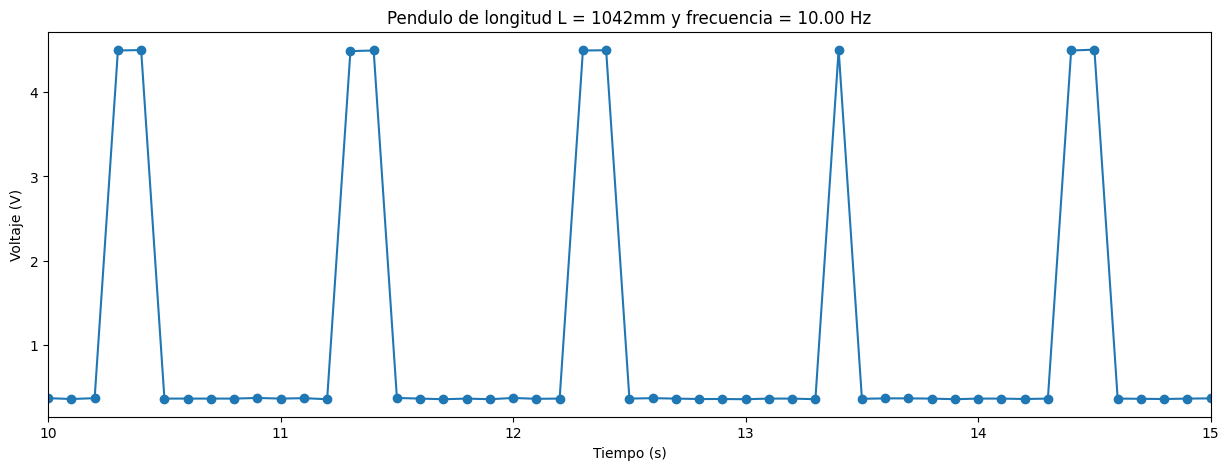

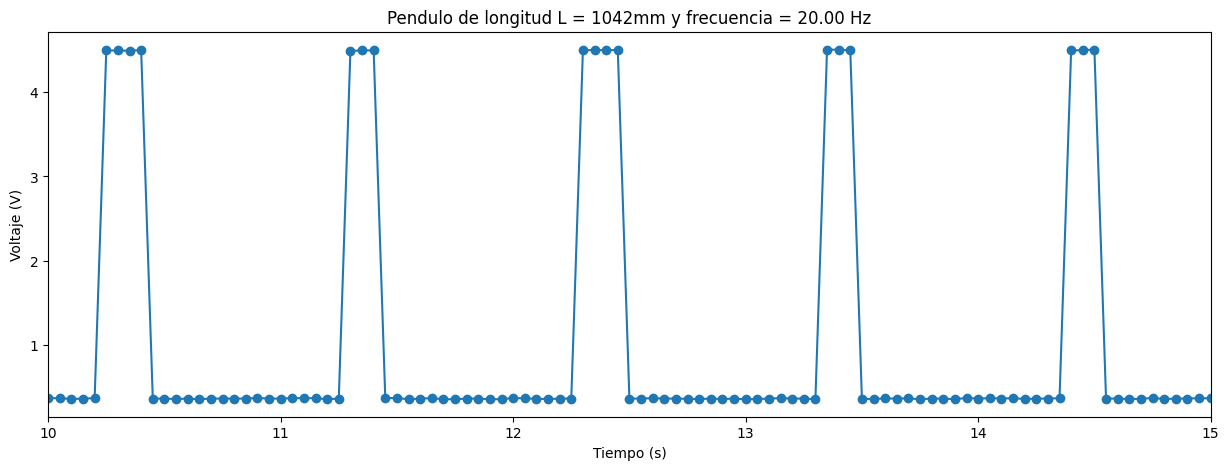

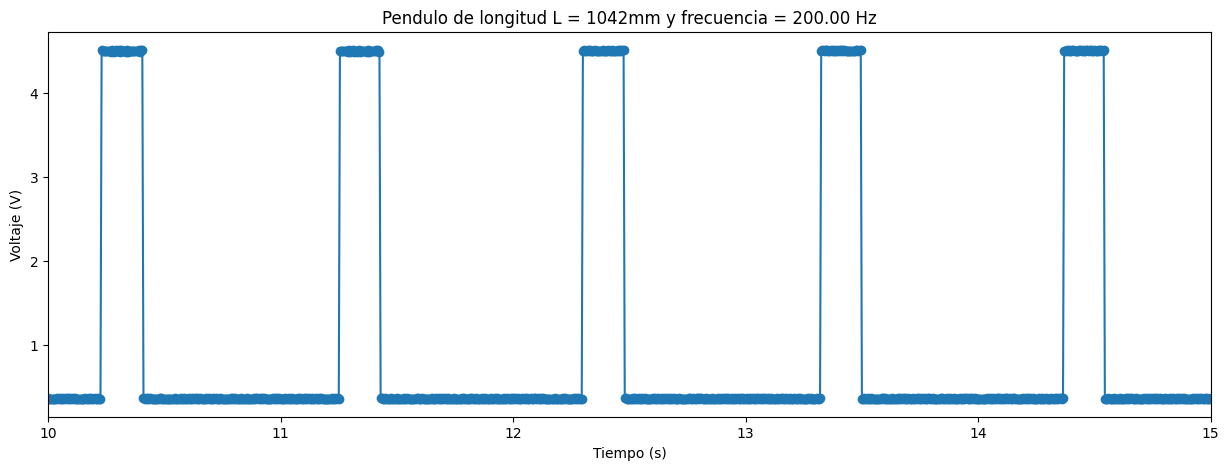

In [102]:
freqs = [1/10, 1/20, 1/200]

for freq in freqs:
    a = (df['1042mm'].index).tolist()
    result = [is_multiple(num, freq) for num in a]
    df_low_freq = df[result]

    fig = plt.figure(figsize=(15,5))
    df_low_freq['1042mm'].plot(style="-o")
    plt.title(f"Pendulo de longitud L = {'1042mm'} y frecuencia = {1/freq:.2f} Hz")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.xlim([10, 15])
    plt.show()

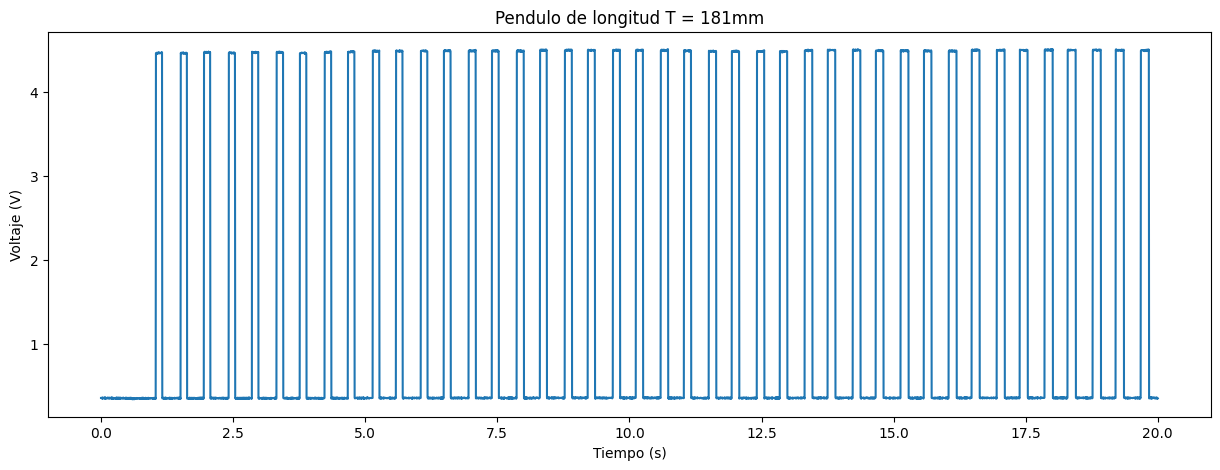

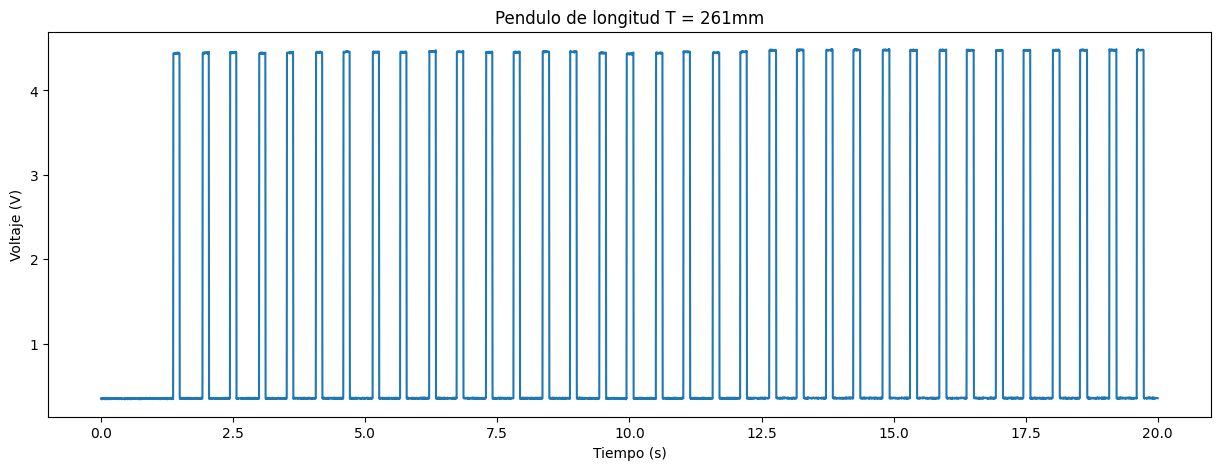

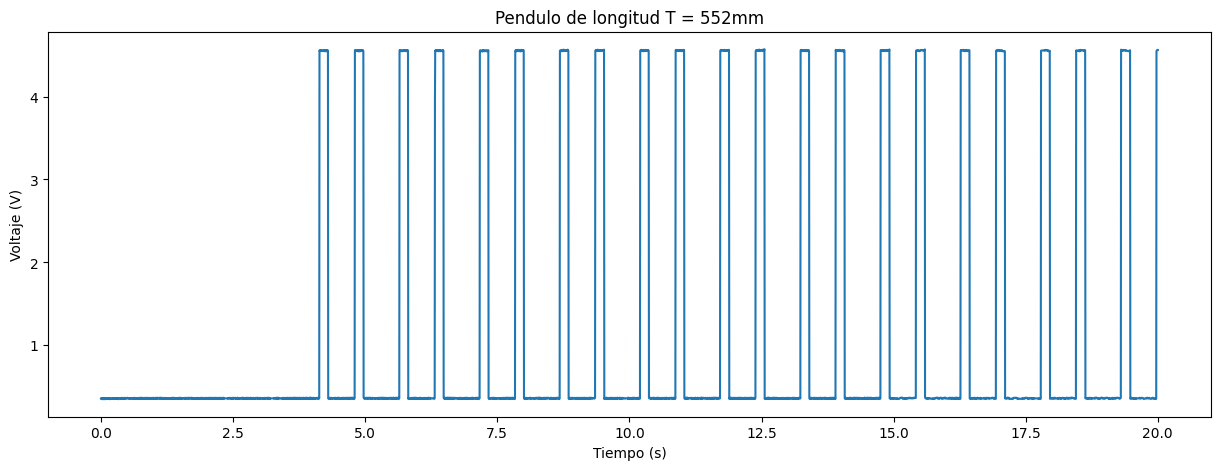

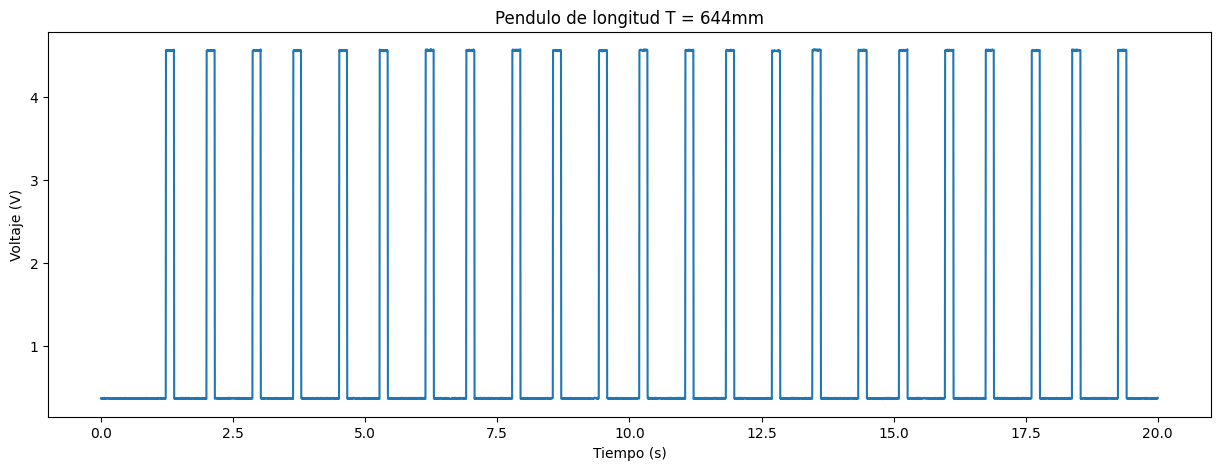

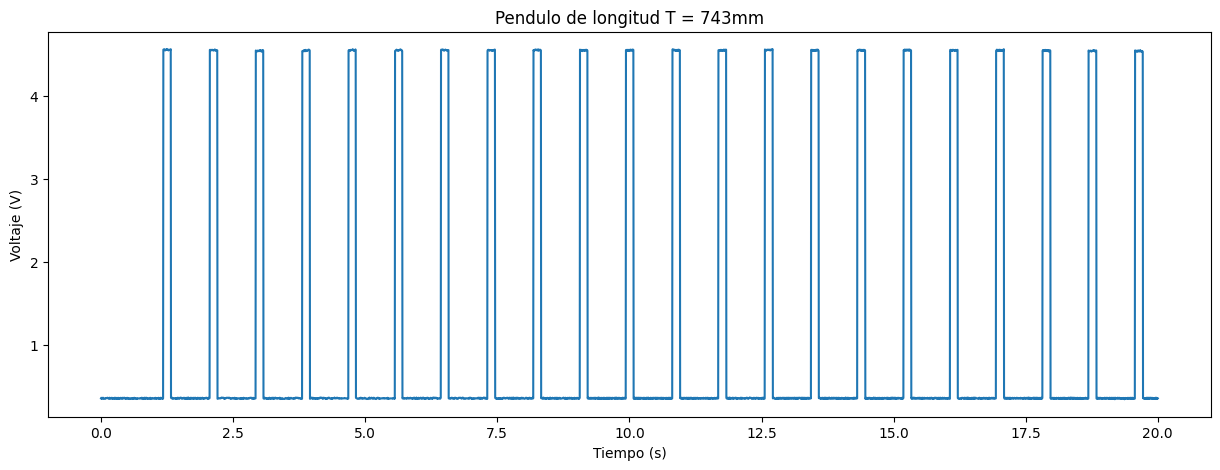

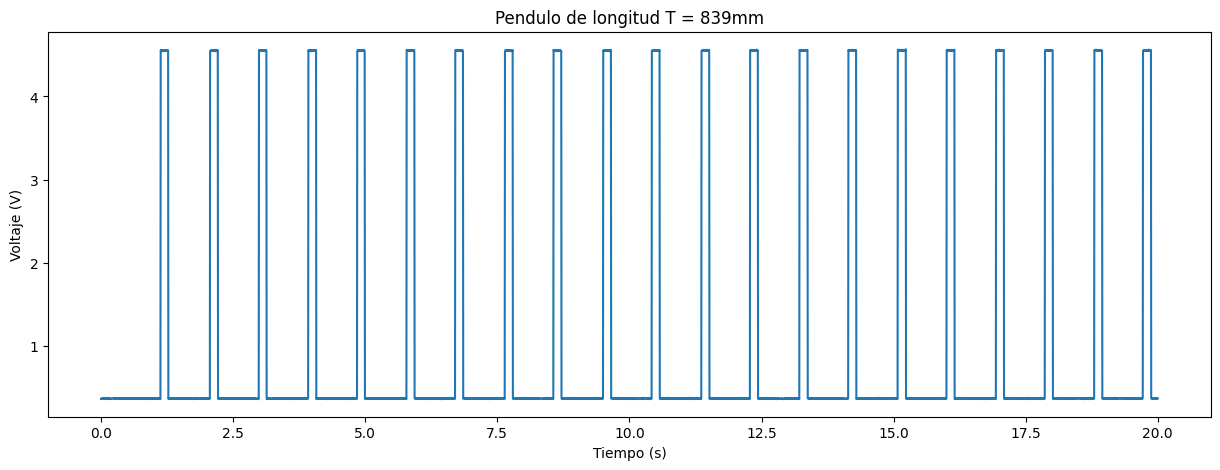

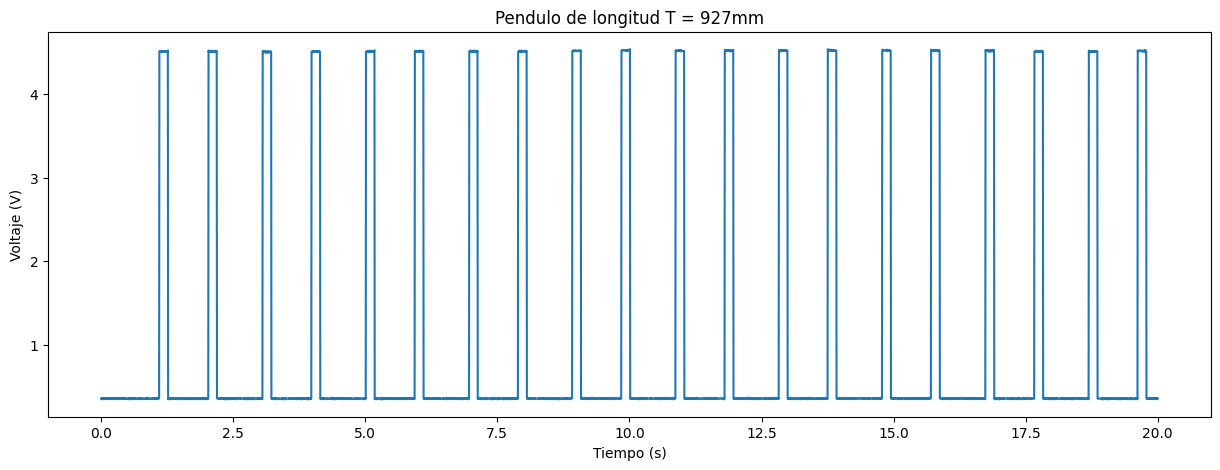

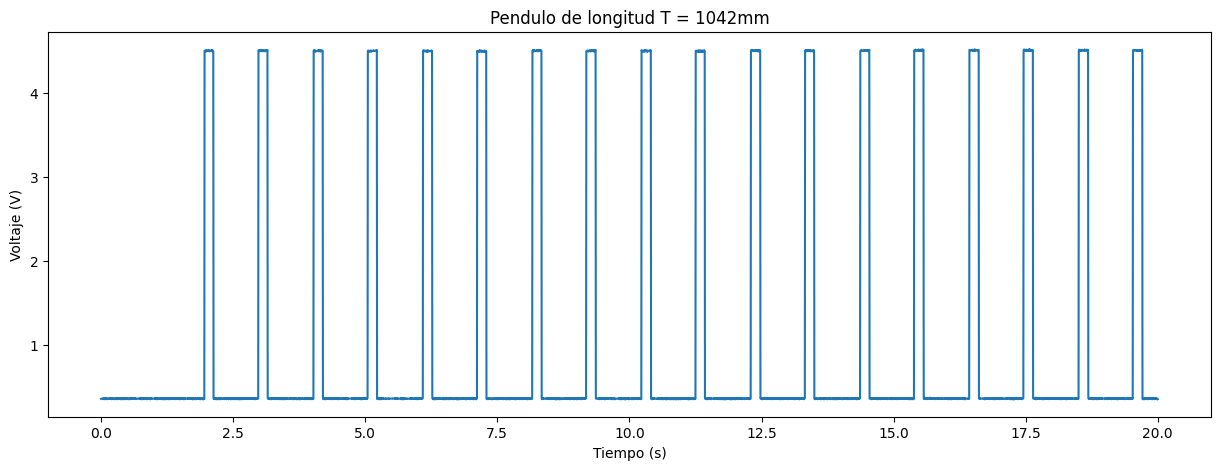

In [103]:
# Grafico todas las señales
for c in columns:
    plt.figure(figsize=(15,5))
    df[c].plot()
    plt.title(f"Pendulo de longitud T = {c}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.show()

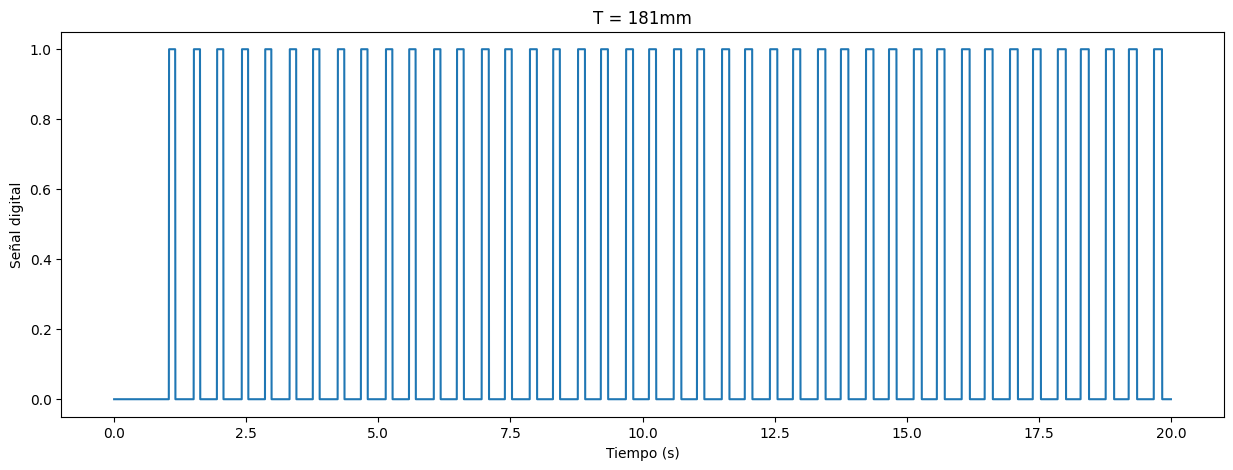

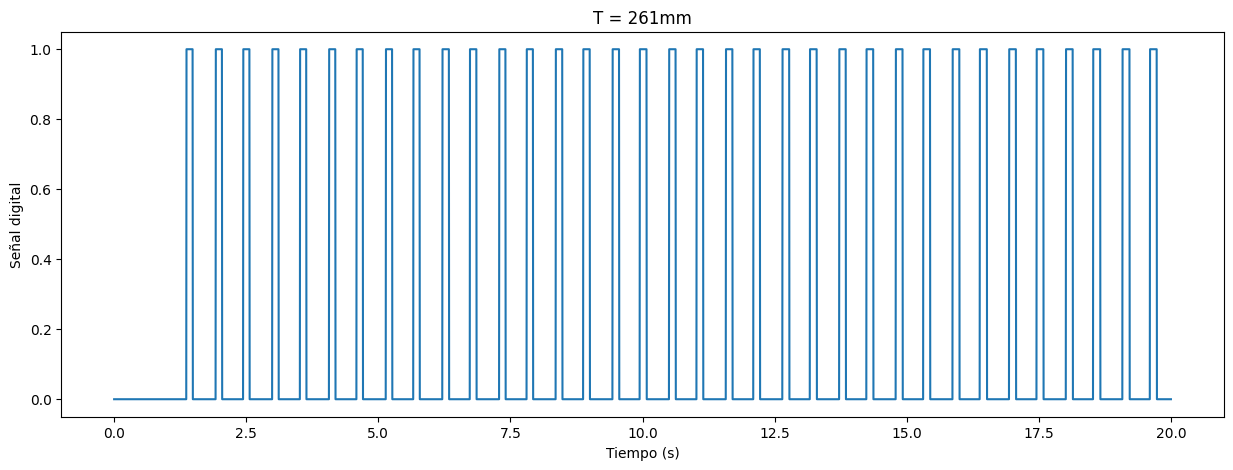

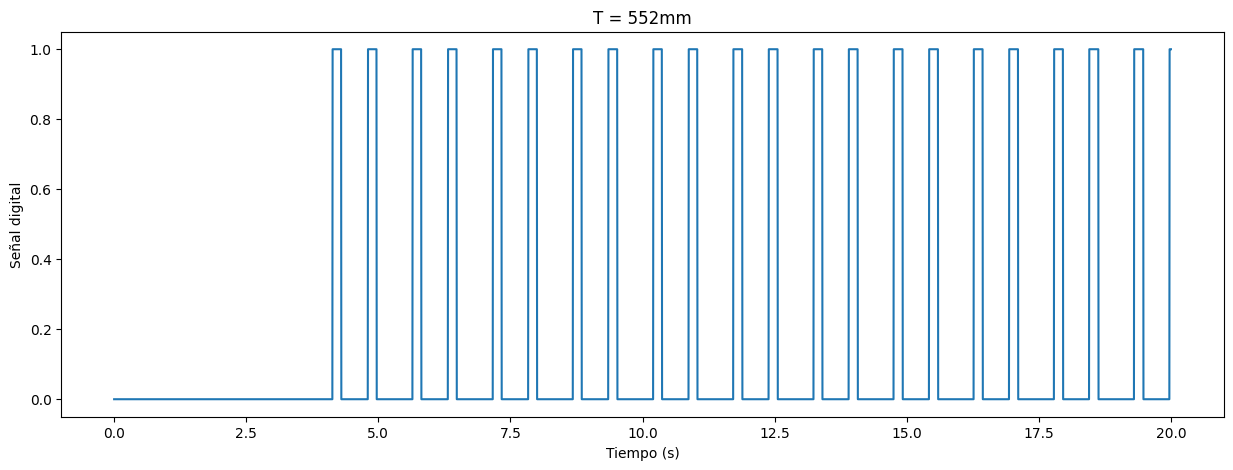

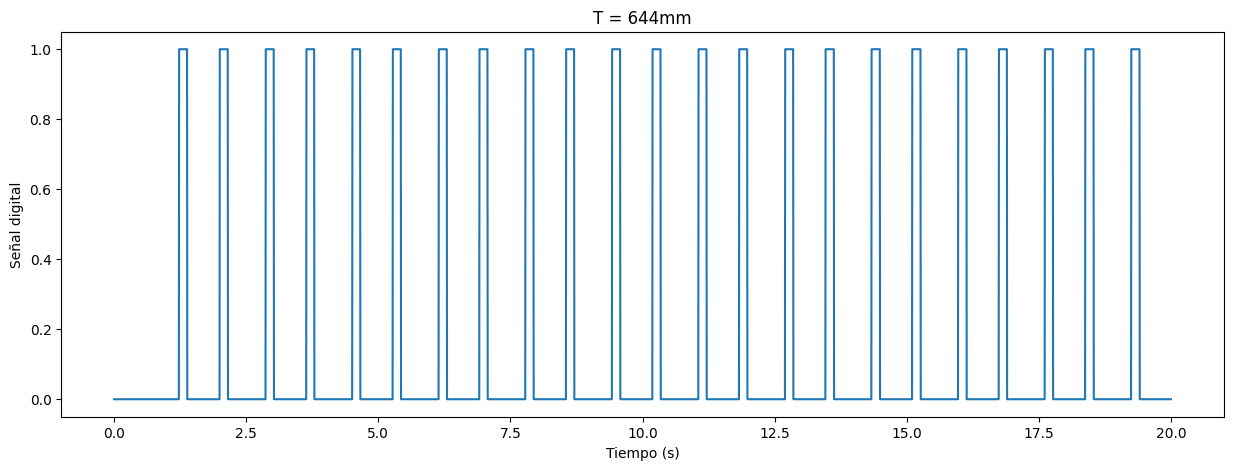

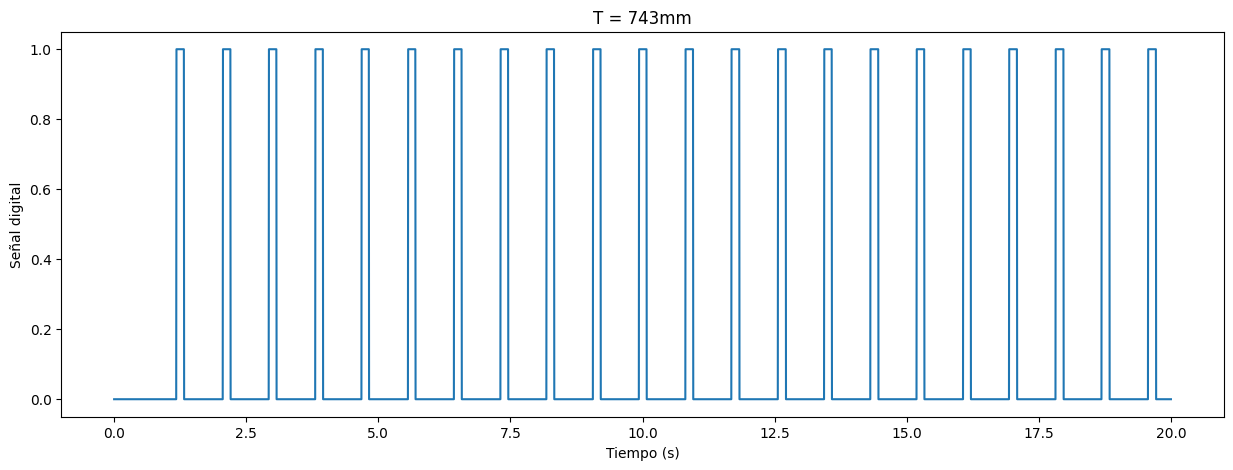

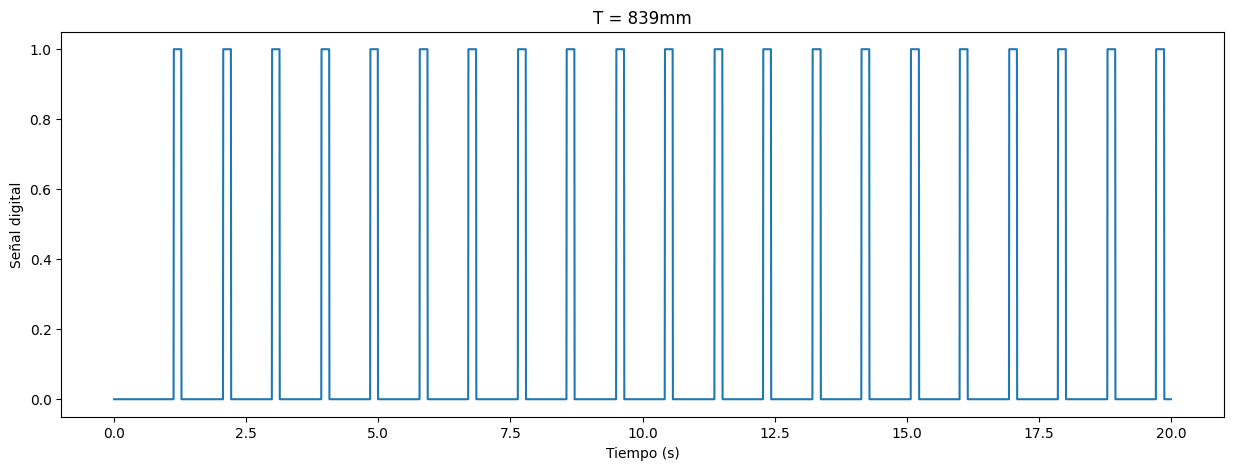

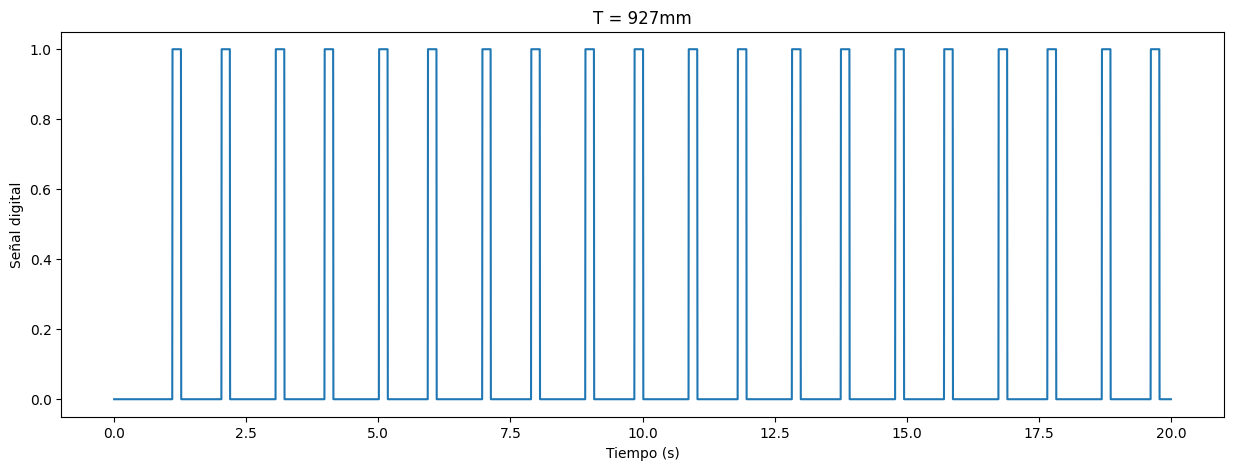

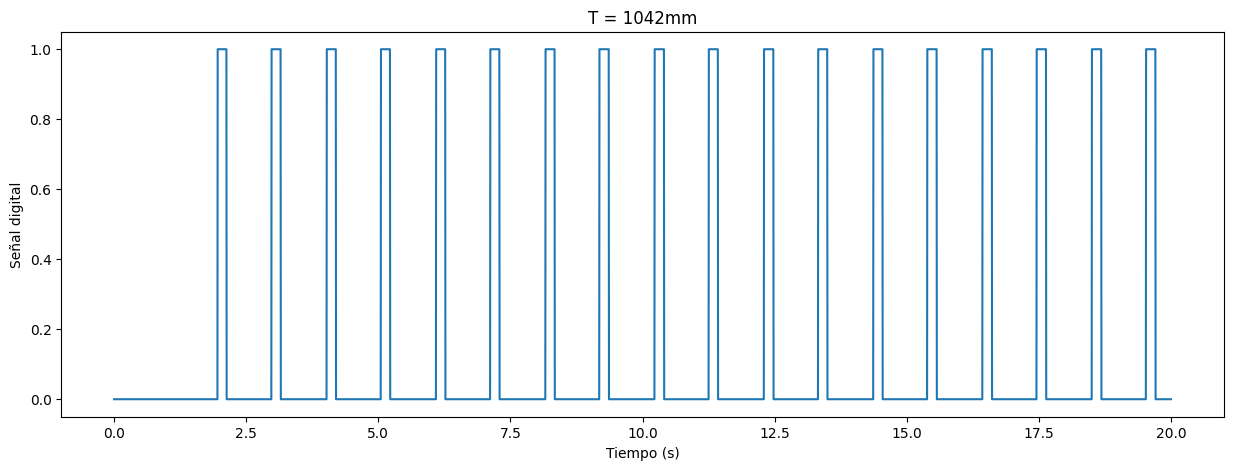

In [104]:
# Duplico y digitalizo cada columna: Si V es mayor a 3, entonces 1, sino 0
df_digital = df.apply(lambda x: x > 3).astype(int)

# Señales digitales
for c in columns:
    plt.figure(figsize=(15,5))
    df_digital[c].plot()
    plt.title(f"T = {c}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Señal digital")
    plt.show()

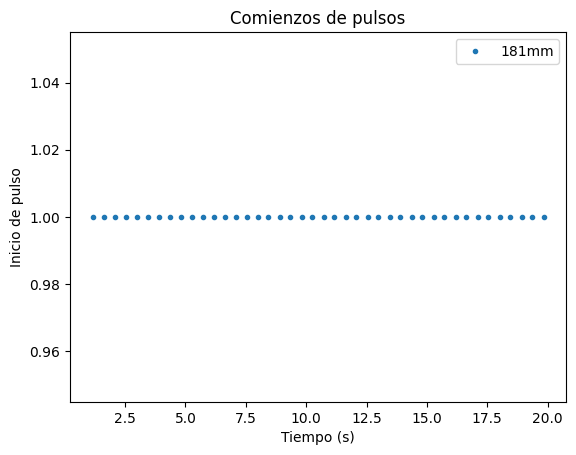

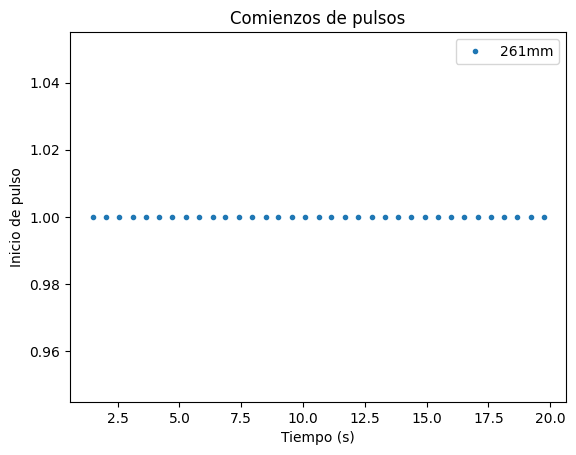

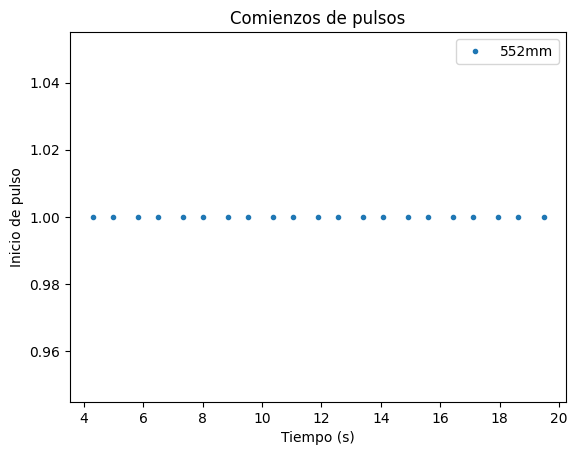

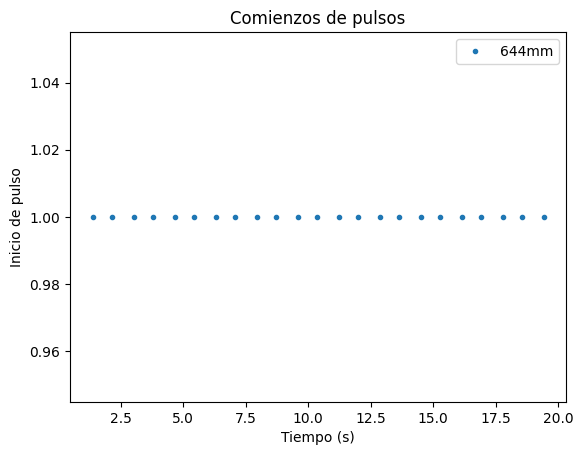

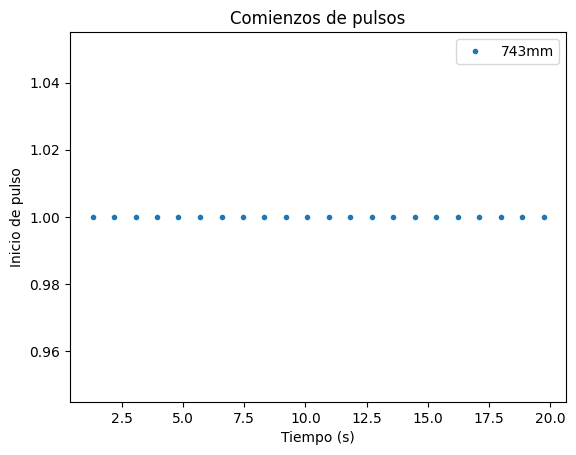

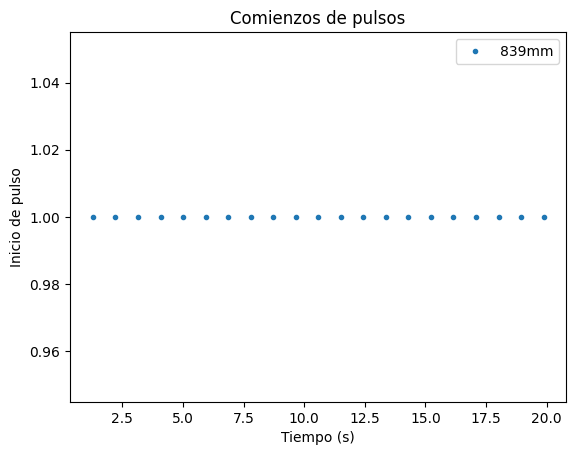

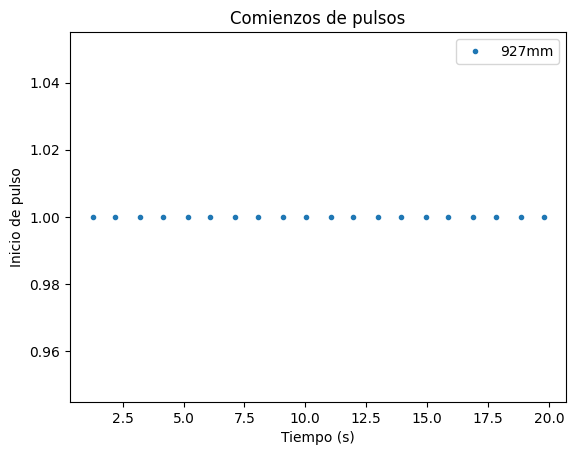

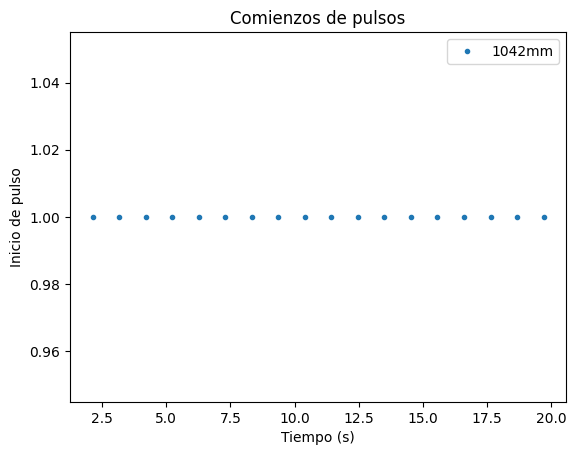

In [105]:
# Creo lista de dataframes solo con los comienzos de cada pulso
starts_dfs = [df_digital[c].diff().apply(lambda x: x == -1).astype(int) for c in columns]

# Borro filas con zeros de cada df
starts_dfs = [df[df == 1].dropna() for df in starts_dfs]

for s in starts_dfs:
    s.plot(style='.')
    plt.title("Comienzos de pulsos")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Inicio de pulso")
    plt.legend()
    plt.show()

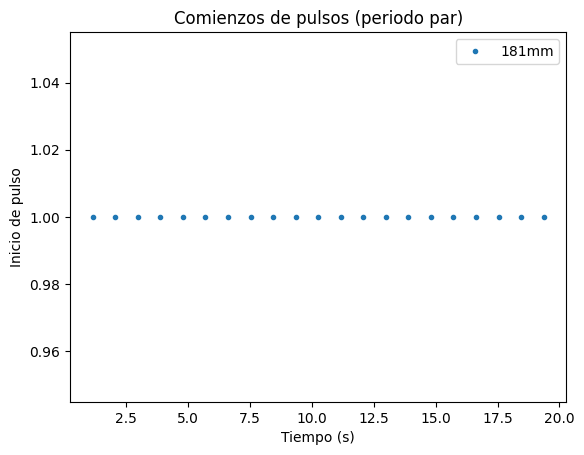

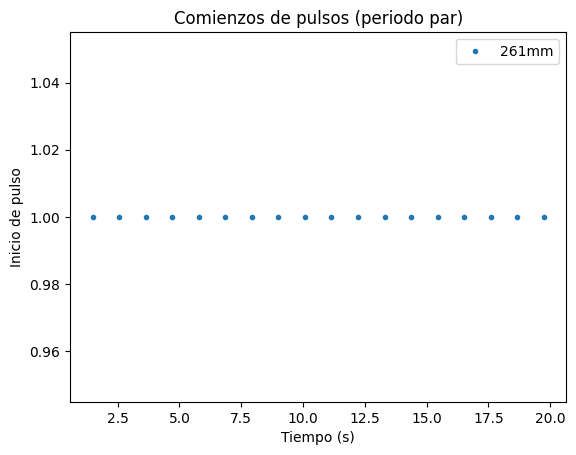

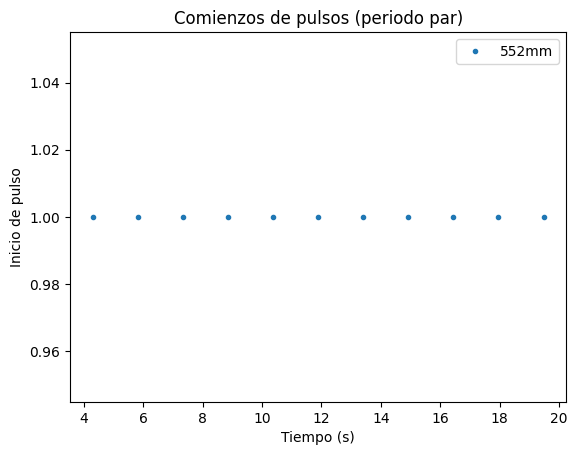

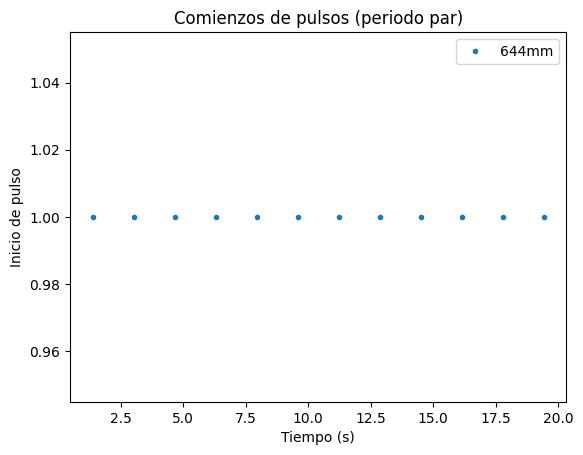

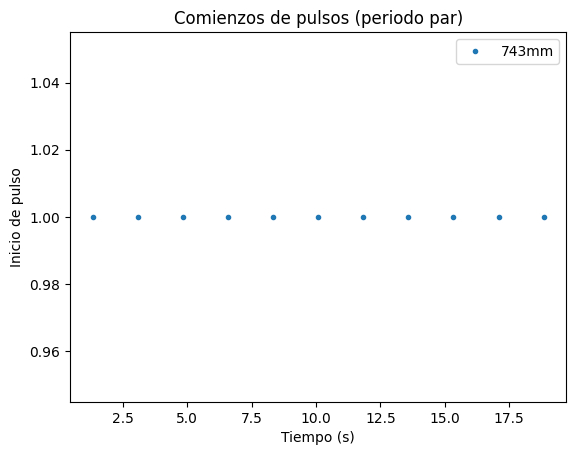

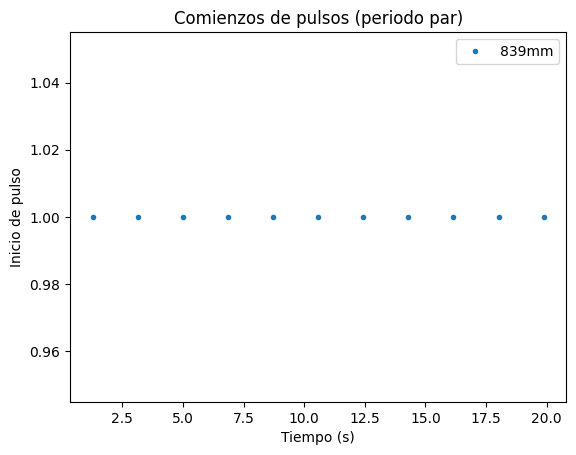

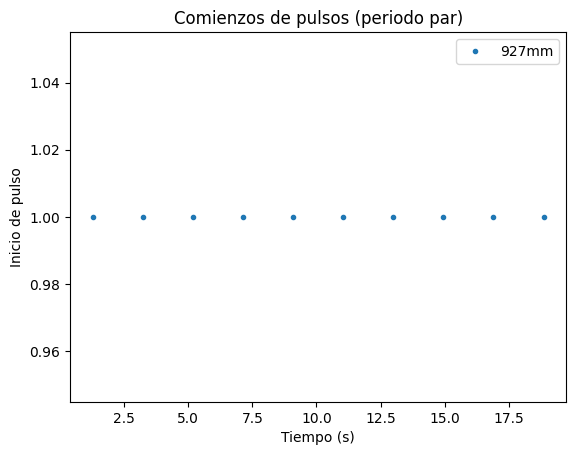

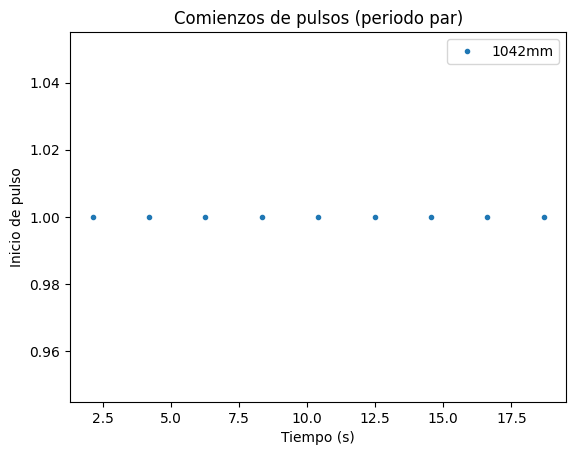

In [106]:
# Separo filas pares e impares
even_period_dfs = [df.iloc[::2] for df in starts_dfs]
odd_period_dfs = [df.iloc[1::2] for df in starts_dfs]


for p in even_period_dfs:
    p.plot(style='.')
    plt.title("Comienzos de pulsos (periodo par)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Inicio de pulso")
    plt.legend()

    plt.show()

In [107]:
# Convierto index como columna de tiempo
even_period_dfs = [df.reset_index(inplace=False) for df in even_period_dfs]
odd_period_dfs = [df.reset_index(inplace=False) for df in odd_period_dfs]


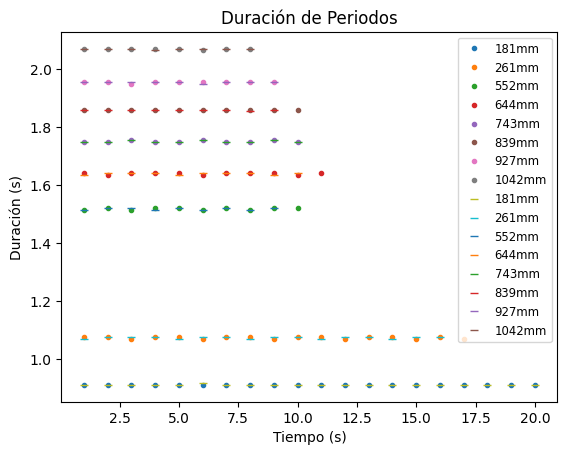

In [108]:
for i in range(len(even_period_dfs)):
    even_period_dfs[i]['time'].diff().plot(style='.')

for i in range(len(odd_period_dfs)):
    odd_period_dfs[i]['time'].diff().plot(style='_')

plt.title("Duración de Periodos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Duración (s)")
plt.legend(columns+columns, fontsize='small')
plt.show()

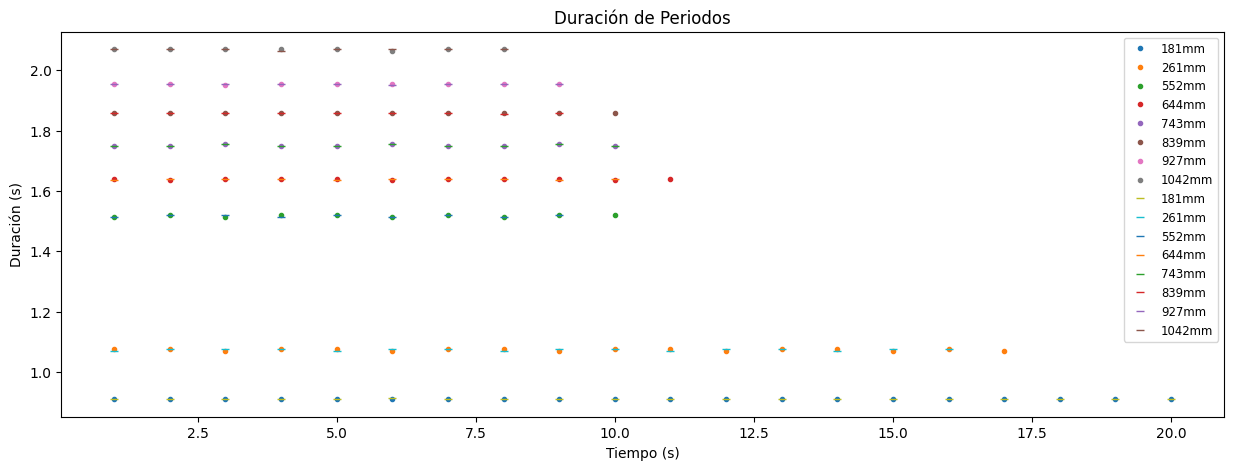

In [109]:

plt.figure(figsize=(15,5))

for i in range(len(even_period_dfs)):
    even_period_dfs[i]['time'].diff().plot(style='.')

for i in range(len(odd_period_dfs)):
    odd_period_dfs[i]['time'].diff().plot(style='_')

plt.title("Duración de Periodos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Duración (s)")
plt.legend(columns+columns, fontsize='small')
plt.show()

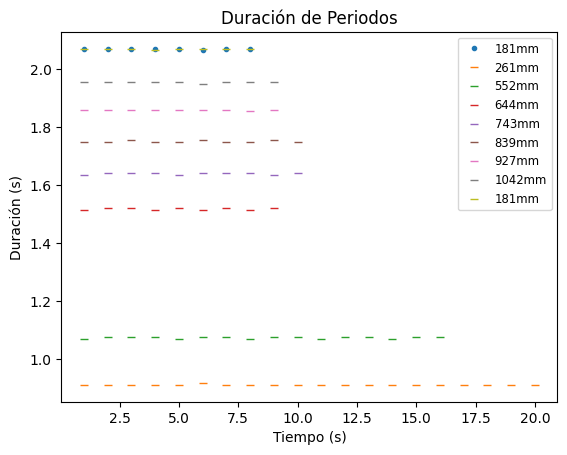

In [110]:
even_period_dfs[i]['time'].diff().plot(style='.')

for i in range(len(odd_period_dfs)):
    odd_period_dfs[i]['time'].diff().plot(style='_')

plt.title("Duración de Periodos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Duración (s)")
plt.legend(columns+columns, fontsize='small')
plt.show()

In [111]:
def get_values(even_df, odd_df):
    return list(even_df['time'].diff().dropna().values) + list(odd_df['time'].diff().dropna().values)

In [112]:

# plt.figure(figsize=(10,5))
# plt.title("Duración de Periodos")
# plt.xlabel("Longitud (mm)")
# plt.ylabel("Duración (s)")

# boxplot_df = pd.DataFrame(columns=['Pendulo', 'Periodo'])

# for i in range(len(even_period_dfs)):
#     data = np.array(get_values(even_period_dfs[i], odd_period_dfs[i]))
#     data = pd.DataFrame({'Pendulo': columns[i], 'Periodo': data})
#     boxplot_df = pd.concat([boxplot_df, data], ignore_index=True)

# sns.boxplot(data=boxplot_df, x="Pendulo", y="Periodo")

# plt.show()

In [113]:
duraciones = [get_values(even_df, odd_df) for even_df, odd_df in zip(even_period_dfs, odd_period_dfs)]

period_means = [np.mean(d) for d in duraciones]
period_stds = [np.std(d) for d in duraciones]
period_amounts = [len(d) for d in duraciones]

g_real = 9.79748

errores = []
errores_porcentuales = []
longitudes = []
periodos = []
periodos_ideales = []

for c, T_est, s, a in zip(columns, period_means, period_stds, period_amounts):
    print(f"L = {c} - {a} mediciones")
    print(f"Periodo medio:   {T_est:.6f}")
    print(f"Desvio estandar: {s:.6f}")
    L = float(c.replace("mm", "")) / 1000

    T_ideal = 2 * np.pi * np.sqrt(L / g_real)
    
    # Local gravity https://www.sensorsone.com/local-gravity-calculator/#local-gravity
    print(f"Periodo esperado: {T_ideal:.6f}")

    error = abs(T_ideal - T_est)
    error_porcentual = error / T_ideal * 100
    print(f"Error: {error:.6f}")
    print(f"Error: {error_porcentual:.6f}%")
    errores.append(error)
    errores_porcentuales.append(error_porcentual)
    longitudes.append(L)
    periodos.append(T_est)
    periodos_ideales.append(T_ideal)
    print("-"*50)


L = 181mm - 40 mediciones
Periodo medio:   0.910125
Desvio estandar: 0.000781
Periodo esperado: 0.854008
Error: 0.056117
Error: 6.571010%
--------------------------------------------------
L = 261mm - 33 mediciones
Periodo medio:   1.073333
Desvio estandar: 0.002357
Periodo esperado: 1.025517
Error: 0.047816
Error: 4.662641%
--------------------------------------------------
L = 552mm - 19 mediciones
Periodo medio:   1.517895
Desvio estandar: 0.002469
Periodo esperado: 1.491393
Error: 0.026501
Error: 1.776952%
--------------------------------------------------
L = 644mm - 21 mediciones
Periodo medio:   1.638571
Desvio estandar: 0.002259
Periodo esperado: 1.610889
Error: 0.027682
Error: 1.718458%
--------------------------------------------------
L = 743mm - 20 mediciones
Periodo medio:   1.751500
Desvio estandar: 0.002291
Periodo esperado: 1.730283
Error: 0.021217
Error: 1.226229%
--------------------------------------------------
L = 839mm - 19 mediciones
Periodo medio:   1.859737
Des

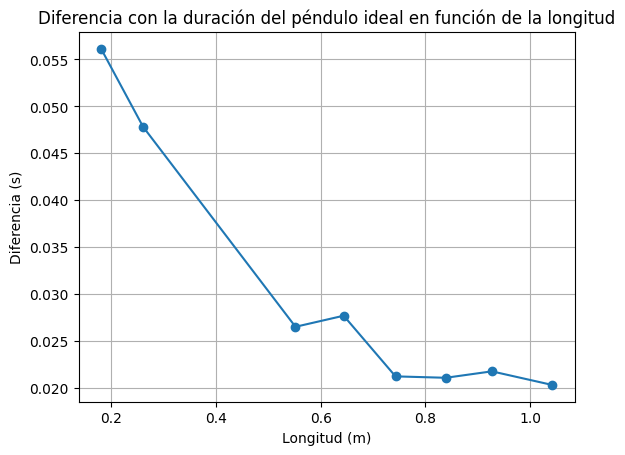

In [114]:
plt.plot(longitudes, errores, '-o')
plt.xlabel("Longitud (m)")
plt.ylabel("Diferencia (s)")
plt.title("Diferencia con la duración del péndulo ideal en función de la longitud")
plt.grid()
# Add vertical line and xtick in x axis at each x point value
#plt.xticks(longitudes)

plt.show()


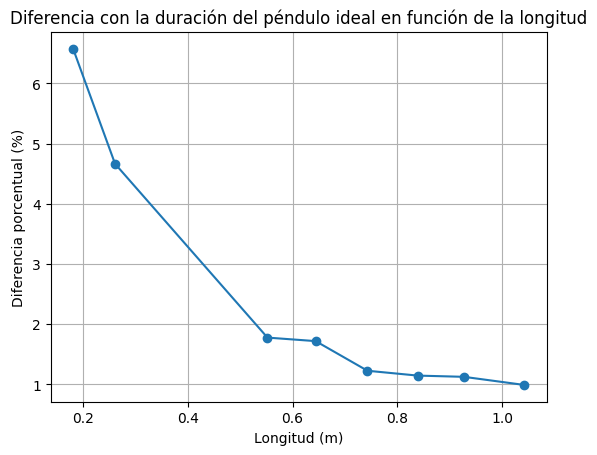

In [115]:
plt.plot(longitudes, errores_porcentuales, '-o')
plt.xlabel("Longitud (m)")
plt.ylabel("Diferencia porcentual (%)")
plt.title("Diferencia con la duración del péndulo ideal en función de la longitud")
plt.grid()
# Add vertical line and xtick in x axis at each x point value
#plt.xticks(longitudes)

plt.show()

In [116]:
# 2 A
#Veamos Ta incerteza en la longitud del hilo T y el periodo T

def deltaL(L):  # no considera errores estadísticos
    return 0.001 # error instrumental de 1 mm

error_nominal_T = np.sqrt(2) * 1/200

def deltaT(desv, n):
    return np.sqrt(error_nominal_T ** 2 + (desv / np.sqrt(n)) ** 2)

incertezas = pd.DataFrame(columns=['L', 'dL', 'T', 'dT'])
for c, T, s, n, L in zip(columns, period_means, period_stds, period_amounts, longitudes):
    incertezas.loc[len(incertezas)] = [L, deltaL(L), np.round(T, 3), deltaT(s, n)]

incertezas

,L,dL,T,dT
0,0.181,0.001,0.910,0.007072
1,0.261,0.001,1.073,0.007083
2,0.552,0.001,1.518,0.007094
3,0.644,0.001,1.639,0.007088
4,0.743,0.001,1.752,0.007090
5,0.839,0.001,1.860,0.007076
6,0.927,0.001,1.954,0.007081
7,1.042,0.001,2.069,0.007083


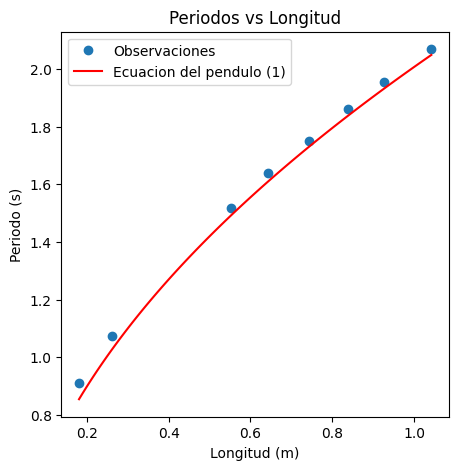

In [117]:
# 2 B

plt.figure(figsize=(5,5))
plt.title("Periodos vs Longitud")
plt.xlabel("Longitud (m)")
plt.ylabel("Periodo (s)")

plt.plot(incertezas['L'], incertezas['T'], 'o', label='Observaciones')

x_values = np.linspace(min(incertezas['L']), max(incertezas['L']), 100)

def ecuacion_del_pendulo(l):
    return 2 * np.pi * np.sqrt(l/g_real)

plt.plot(x_values, ecuacion_del_pendulo(x_values), color='red', label='Ecuacion del pendulo (1)')

plt.legend()

plt.show()


In [118]:
# 2 C

def delta_sqrtL(L, dL):
    return 1 / (2 * np.sqrt(L)) * dL

incertezas['sqrt_L'] = incertezas.apply(lambda row: np.sqrt(row['L']), axis=1)
incertezas['d_sqrt_L'] = incertezas.apply(lambda row: delta_sqrtL(row['L'], row['dL']), axis=1)

def delta_T2(T, dT):
    return 2 * T * dT

incertezas['T2'] = incertezas.apply(lambda row: row['T'] ** 2, axis=1)
incertezas['d_T2'] = incertezas.apply(lambda row: delta_T2(row['T'], row['dT']), axis=1)

incertezas

,L,dL,T,dT,sqrt_L,d_sqrt_L,T2,d_T2
0,0.181,0.001,0.910,0.007072,0.425441,0.001175,0.828100,0.012871
1,0.261,0.001,1.073,0.007083,0.510882,0.000979,1.151329,0.015200
2,0.552,0.001,1.518,0.007094,0.742967,0.000673,2.304324,0.021537
3,0.644,0.001,1.639,0.007088,0.802496,0.000623,2.686321,0.023235
4,0.743,0.001,1.752,0.007090,0.861974,0.000580,3.069504,0.024842
5,0.839,0.001,1.860,0.007076,0.915969,0.000546,3.459600,0.026322
6,0.927,0.001,1.954,0.007081,0.962808,0.000519,3.818116,0.027672
7,1.042,0.001,2.069,0.007083,1.020784,0.000490,4.280761,0.029310


In [119]:
def error_relativo(dX, X):
    return dX / X

def mayorError(df):
    T_vs_SqrtL = []
    T2_vs_L = []
    erroresRelativosT = []
    erroresRelativosL = []
    erroresRelativosT2 = []
    erroresRelativos_sqrtL = []


    for index, row in df.iterrows():
        errorRelativoT = 100 * error_relativo(row['dT'], row['T']) 
        errorRelativoT = np.round(errorRelativoT, 2)

        errorRelativoL = 100 * error_relativo(row['dL'], row['L'])
        errorRelativoL = np.round(errorRelativoL, 2)

        errorRelativoT2 = 100 * error_relativo(row['d_T2'], row['T2'])
        errorRelativoT2 = np.round(errorRelativoT2, 2)

        errorRelativo_sqrt_L = 100 * error_relativo(row['d_sqrt_L'], row['sqrt_L'])
        errorRelativo_sqrt_L = np.round(errorRelativo_sqrt_L, 2)

        if errorRelativoT > errorRelativo_sqrt_L:
            T_vs_SqrtL.append("T")
        else:
            T_vs_SqrtL.append("sqrtL")

        if errorRelativoT2 > errorRelativoL:
            T2_vs_L.append("T2")
        else:
            T2_vs_L.append("L")

        erroresRelativosT.append(errorRelativoT)
        erroresRelativosL.append(errorRelativoL)
        erroresRelativosT2.append(errorRelativoT2)
        erroresRelativos_sqrtL.append(errorRelativo_sqrt_L)

    return (T_vs_SqrtL, T2_vs_L, erroresRelativosT, erroresRelativosL, erroresRelativos_sqrtL, erroresRelativosT2)


T_vs_SqrtL, T2_vs_L, erroresRelativosT, erroresRelativosL, erroresRelativos_sqrtL, erroresRelativosT2 = mayorError(incertezas)

print("T:", erroresRelativosT)

print("Sqrt L:", erroresRelativos_sqrtL)

print("T^2:", erroresRelativosT2)

print("L:", erroresRelativosL)

print()

print("T vs Sqrt L:", T_vs_SqrtL)

print("T^2 vs L:", T2_vs_L)

T: [0.78, 0.66, 0.47, 0.43, 0.4, 0.38, 0.36, 0.34]
Sqrt L: [0.28, 0.19, 0.09, 0.08, 0.07, 0.06, 0.05, 0.05]
T^2: [1.55, 1.32, 0.93, 0.86, 0.81, 0.76, 0.72, 0.68]
L: [0.55, 0.38, 0.18, 0.16, 0.13, 0.12, 0.11, 0.1]

T vs Sqrt L: ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
T^2 vs L: ['T2', 'T2', 'T2', 'T2', 'T2', 'T2', 'T2', 'T2']


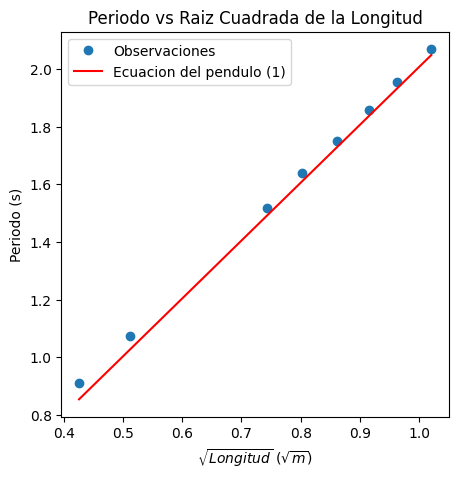

In [120]:
plt.figure(figsize=(5,5))
plt.title("Periodo vs Raiz Cuadrada de la Longitud")
plt.xlabel((r"$\sqrt{ {Longitud}}$ ($\sqrt{m}$)"))
plt.ylabel("Periodo (s)")

plt.plot(incertezas['sqrt_L'], incertezas['T'], 'o', label='Observaciones')

x_values = np.linspace(min(incertezas['sqrt_L']), max(incertezas['sqrt_L']), 100)

def ecuacion_del_pendulo_2(sqrt_l):
    return 2 * np.pi * sqrt_l / np.sqrt(g_real)

plt.plot(x_values, ecuacion_del_pendulo_2(x_values), color='red', label='Ecuacion del pendulo (1)')

plt.legend()

plt.show()



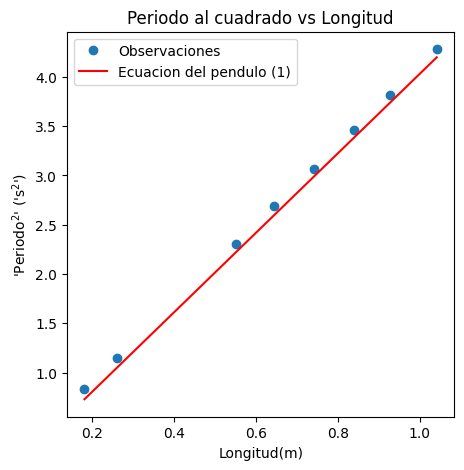

In [121]:
plt.figure(figsize=(5,5))
plt.title("Periodo al cuadrado vs Longitud")
plt.xlabel(("Longitud(m)"))
plt.ylabel((r"'Periodo$^2$' ('s$^2$')"))

plt.plot(incertezas['L'], incertezas['T2'], 'o', label='Observaciones')


x_values = np.linspace(min(incertezas['L']), max(incertezas['L']), 100)

def ecuacion_del_pendulo_3(L):
    return 4 * np.pi**2 * L / g_real

plt.plot(x_values, ecuacion_del_pendulo_3(x_values), color='red', label='Ecuacion del pendulo (1)')

plt.legend()

plt.show()


## Ajustes Lineales

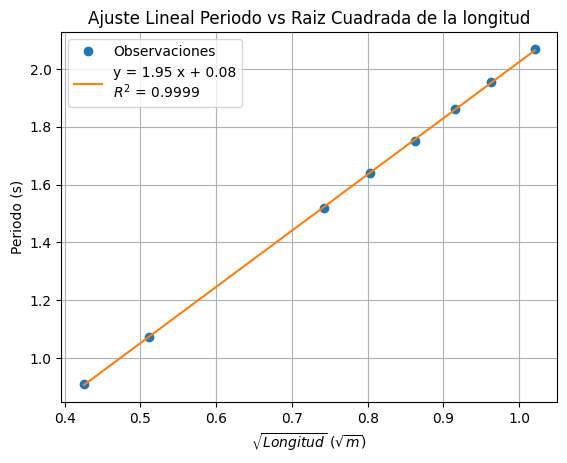

Valor de g = 10.434762027020172 +- 0.1349683347245362


In [122]:
# 2 E

def lineal(x, a, b):
    return a * x + b

def fit_with_curve_fit(lineal, x, y, y_err):
    popt, pcov = curve_fit(lineal, x, y, sigma=y_err, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    print(f"Pendiente (a) = {popt[0]} ± {perr[0]}")
    print(f"Intersección (b) = {popt[1]} ± {perr[1]}")
    return popt[0], popt[1], perr[0], perr[1]

a, b, da, db = fit_with_curve_fit(lineal, incertezas['sqrt_L'], incertezas['T'], incertezas['dT'])

R2 = 1 - np.sum((lineal(incertezas['sqrt_L'], a, b) - incertezas['T'])**2) / np.sum((incertezas['T'] - np.mean(incertezas['T']))**2)

plt.plot(incertezas['sqrt_L'], incertezas['T'], 'o', label='Observaciones')

plt.plot(incertezas['sqrt_L'], lineal(incertezas['sqrt_L'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel((r"$\sqrt{ {Longitud}}$ ($\sqrt{m}$)"))
plt.ylabel("Periodo (s)")
plt.title("Ajuste Lineal Periodo vs Raiz Cuadrada de la longitud")
plt.legend()
plt.grid()
plt.show()


# calculemos g
g1 = 4*np.pi**2/a**2
dg1 = 8*np.pi**2/a**3 * da
print(f"Valor de g = {g1} +- {dg1}")

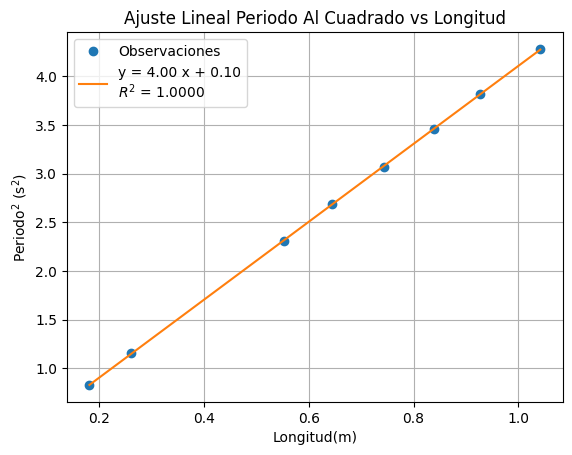

Valor de g = 9.86417954543595 +- 0.05918355347283075


In [123]:
a, b, da, db = fit_with_curve_fit(lineal, incertezas['L'], incertezas['T2'], incertezas['d_T2'])

R2 = 1 - np.sum((lineal(incertezas['L'], a, b) - incertezas['T2'])**2) / np.sum((incertezas['T2'] - np.mean(incertezas['T2']))**2)

plt.plot(incertezas['L'], incertezas['T2'], 'o', label='Observaciones')

plt.plot(incertezas['L'], lineal(incertezas['L'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel("Longitud(m)")
plt.ylabel(r"Periodo$^2$ (s$^2$)")
plt.title("Ajuste Lineal Periodo Al Cuadrado vs Longitud")
plt.legend()
plt.grid()
plt.show()

# calculemos g
g2 = 4*np.pi**2/a
dg2 = 4*np.pi**2/a**2 * da
print(f"Valor de g = {g2} +- {dg2}")